<a href="https://colab.research.google.com/github/quantaosun/FEgrow/blob/master/notebooks/google-colab-tutoria_modifiedl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

* Add chemical functional groups (R-groups) in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Output structures for free energy calculations

## Overview

This notebook demonstrates the entire `FEgrow` workflow for generating a series of ligands with a common core for a specific binding site, via the addition of a user-defined set of R-groups. 

These *de novo* ligands are then subjected to ADMET analysis. Valid conformers of the added R-groups are enumerated, and optimised in the context of the receptor binding pocket, optionally using hybrid machine learning / molecular mechanics potentials (ML/MM).

An ensemble of low energy conformers is generated for each ligand, and scored using the `gnina` convolutional neural network (CNN). Output structures are saved as `pdb` files ready for use in free energy calculations.

The target for this tutorial is the main protease (Mpro) of SARS-CoV-2, and the core and receptor structures are taken from a [recent study by Jorgensen & co-workers](https://doi.org/10.1021/acscentsci.1c00039).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!conda install -c conda-forge rdkit prody
!conda install -c conda-forge openff-toolkit-base -y
!conda install -c conda-forge parmed -y

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - prody
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    appdirs-1.4.4              |     pyh9f0ad1d_0          13 KB  conda-forge
    biopython-1.80             |   py38h0a891b7_0         2.4 MB  conda-forge
    boost-1.78.0               |   py38h4e30db6_4         369 KB  conda-forge
    boost-cpp-1.78.0           |       h75c5d50_1        17.1 MB  conda-forge
    brotli-1.0.9               |       h166bdaf_8          18 KB  conda-forge
    brotli-bin-1.0.9           |       h166bdaf_8          20 KB  conda-forge
    ca-cer

In [3]:
!conda install -c conda-forge openmmforcefields -y

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [4]:
!conda install -c conda-forge typing-extensions -y


Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [ ]:
!conda install -c conda-forge pdbfixer -y


In [ ]:
!conda install -c conda-forge typing tqdm openbabel -y


In [ ]:
#@title added by Q
!mamba install pytorch torchvision -c pytorch
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu100/torch_nightly.html

In [ ]:
!conda install -c conda-forge torchani 

In [ ]:
!conda install -c conda-forge pytorch 

In [ ]:
!conda install -c conda-forge openmm pint -y

In [ ]:
!conda install -c conda-forge py3dmol

In [ ]:
!conda install -c conda-forge mols2grid

In [ ]:
!git clone https://github.com/cole-group/FEgrow.git

In [ ]:
%cd FEgrow

In [ ]:
!pip install .

In [ ]:
!python -m ipykernel install --user --name=fegrow

In [ ]:
#!python setup.cfg

In [ ]:
import copy

import prody
from rdkit import Chem

import fegrow
from fegrow import RGroups

# Prepare the ligand template

The provided core structure `lig.pdb` has been extracted from a crystal structure of Mpro in complex with compound **4** from the Jorgensen study (PDB: 7L10), and a Cl atom has been removed to allow growth into the S3/S4 pocket. The template structure of the ligand is protonated with [Open Babel](http://openbabel.org/wiki/Main_Page):

In [ ]:
%cd notebooks

In [ ]:
#Copy your prot_lig_prod_1.pdb here

In [ ]:
#@title Write out a script for pymol
com_file = open('split.pml','w')
com_file.write('''
load prot_lig_prod_1.pdb
remove resn HOH
h_add elem O or elem N
select LIG, resn LIG #Create a selection called 1OYT-FSN from the ligand
select receptor, prot_lig_prod_1 and not LIG #Select all that is not the ligand
save LIG.pdb, LIG
save receptor.pdb, receptor    
''')
com_file.close()

In [ ]:
#@title Split prot_lig_prod_1.pdb
! pymol -c split.pml

In [22]:
!obabel sarscov2/Docked1.pdb -O sarscov2/coreh.sdf -p 7

1 molecule converted


Load the protonated ligand into FEgrow:

In [23]:
init_mol = Chem.SDMolSupplier('sarscov2/coreh.sdf', removeHs=False)[0]

# get the FEgrow representation of the rdkit Mol
template_mol = fegrow.RMol(init_mol)

Show the 2D (with indices) representation of the core. This is used to select the desired growth vector.

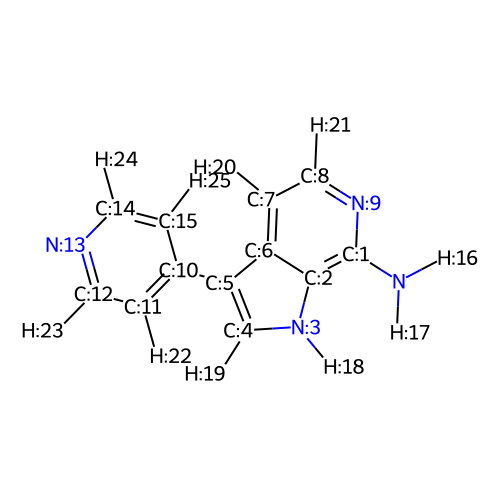

In [24]:
template_mol.rep2D(idx=True, size=(500, 500))

Using the 2D drawing, select an index for the growth vector. Note that it is currently only possible to grow from hydrogen atom positions. In this case, we are selecting the hydrogen atom labelled H:40 to enable growth into the S3/S4 pocket of Mpro.

In [25]:
attachment_index = [18]

R-groups can be selected interactively or programmaticaly.

We have provided a set of common R-groups (see `fegrow/data/rgroups/library`), which can be browsed and selected interactively below.

Molecules from the library can alternatively be selected by name, as demonstrated below.

Finally, user-defined R-groups may be provided as `.mol` files. *In this case, the hydrogen atom selected for attachment should be replaced by the element symbol R.* See the directory `manual_rgroups` for examples.

In [36]:
# interactive selection
RGroups

In [38]:
# retrieve the interactively selected groups
interactive_rgroups = RGroups.get_selected()

# you can also directly access the built-in dataframe programmatically
groups = RGroups.dataframe
R_group_ethanol = groups.loc[groups['Name']=='*c1ccc(OC(F)(F)F)cc1']['Mol'].values[0]
R_group_cyclopropane = groups.loc[groups['Name'] == '*c1cccnc1OC' ]['Mol'].values[0]

# add your own R-groups files
R_group_propanol = Chem.MolFromMolFile('manual_rgroups/propan-1-ol-r.mol', removeHs=False)
# make a list of R-group molecule
selected_rgroups = [R_group_propanol, R_group_ethanol, R_group_cyclopropane] +interactive_rgroups
selected_rgroups

# Build a congeneric series

Now that the R-groups have been selected, we merge them with the ligand core:

In [39]:
rmols = fegrow.build_molecules(template_mol, 
                               attachment_index, 
                               selected_rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f97dd108a00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f97dd108dc0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f97dd108e20> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f97dd108e80>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f97dd108a00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f97dd108dc0>


In [40]:
rmols

,Smiles,Molecule
ID,,
0,[H]c1nc([H])c([H])c(-c2c([H])n(OC([H])([H])C([...,<rdkit.Chem.rdchem.Mol object at 0x7f97dd0951c0>
1,[H]c1nc([H])c([H])c(-c2c([H])n(-c3c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7f97dd095880>
2,[H]c1nc(OC([H])([H])[H])c(-n2c([H])c(-c3c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7f97dd095e20>


The R-group library can also be viewed as a 2D grid, or individual molecules can be selected for 3D view (note that the conformation of the R-group has not yet been optimised):

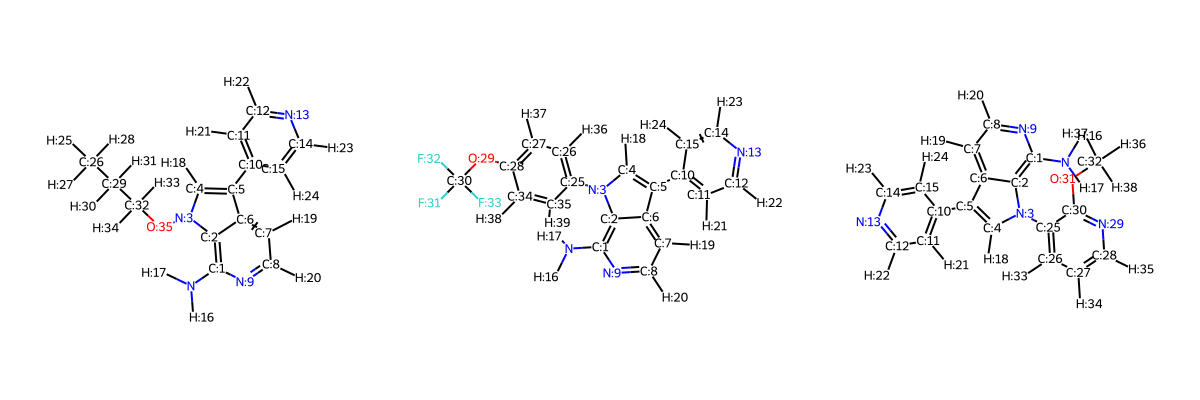

In [41]:
rmols.rep2D()

In [42]:
rmols[1].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Once the ligands have been generated, they can be assessed for various ADMET properties, including Lipinksi rule of 5 properties, the presence of unwanted substructures or problematic functional groups, and synthetic accessibility.

In [43]:
rmols.toxicity()

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility,Smiles,Molecule
ID,,,,,,,,,,,
0,268.320,5,1,2.519,True,False,False,False,7.611642,[H]c1nc([H])c([H])c(-c2c([H])n(OC([H])([H])C([...,<rdkit.Chem.rdchem.Mol object at 0x7f97dd108b80>
1,370.334,5,1,4.568,True,False,False,False,6.921021,[H]c1nc([H])c([H])c(-c2c([H])n(-c3c([H])c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7f97dd095be0>
2,317.352,6,1,3.073,True,False,False,False,7.348505,[H]c1nc(OC([H])([H])[H])c(-n2c([H])c(-c3c([H])...,<rdkit.Chem.rdchem.Mol object at 0x7f97dd0950a0>


For each ligand, a specified number of conformers (`num_conf`) is generated by using the RDKit [ETKDG algorithm](https://doi.org/10.1021/acs.jcim.5b00654). Conformers that are too similar to an existing structure are discarded. Empirically, we have found that `num_conf=200` gives an exhaustive search, and `num_conf=50` gives a reasonable, fast search, in most cases.

If required, a third argument can be added `flexible=[0,1,...]`, which provides a list of additional atoms in the core that are allowed to be flexible. This is useful, for example, if growing from a methyl group and you would like the added R-group to freely rotate.

In [44]:
rmols.generate_conformers(num_conf=50, 
                          minimum_conf_rms=0.5, 
                          # flexible=[3, 18, 20])
                        )

RMol index 0
Removed 28 duplicated conformations, leaving 23 in total. 
RMol index 1
Removed 27 duplicated conformations, leaving 24 in total. 
RMol index 2
Removed 43 duplicated conformations, leaving 8 in total. 


### Prepare the protein

In [45]:
!pwd

/content/FEgrow/notebooks


The protein-ligand complex structure is downloaded, and [PDBFixer](https://github.com/openmm/pdbfixer) is used to protonate the protein, and perform other simple repair:

In [52]:
# get the protein-ligand complex structure
!wget -nc https://files.rcsb.org/download/7L10.pdb

# load the complex with the ligand
sys = prody.parsePDB('final-CLK1-d021-K05014_prepared-receptor.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
rec_final = prody.parsePDB("rec_final.pdb")

File ‘7L10.pdb’ already there; not retrieving.



@> 5556 atoms and 1 coordinate set(s) were parsed in 0.12s.
@> 5558 atoms and 1 coordinate set(s) were parsed in 0.11s.


View enumerated conformers in complex with protein:

In [53]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Any conformers that clash with the protein (any atom-atom distance less than 1 Angstrom), are removed.

In [54]:
rmols.remove_clashing_confs(rec_final)

RMol index 0
Clash with the protein. Removing conformer id: 21
Clash with the protein. Removing conformer id: 19
Clash with the protein. Removing conformer id: 18
Clash with the protein. Removing conformer id: 17
Clash with the protein. Removing conformer id: 16
Clash with the protein. Removing conformer id: 15
Clash with the protein. Removing conformer id: 13
Clash with the protein. Removing conformer id: 12
Clash with the protein. Removing conformer id: 10
Clash with the protein. Removing conformer id: 9
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 7
Clash with the protein. Removing conformer id: 6
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 3
Clash with the protein. Removing conformer id: 2
RMol index 1
Clash with the protein. Removing conformer id: 23
Clash with the protein. Removing conformer id: 22
Clash with the protein. Removing

In [55]:
!cp rec_final.pdb sarscov2

In [56]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Optimise conformers in context of protein

The remaining conformers are optimised using hybrid machine learning / molecular mechanics (ML/MM), using the [ANI2x](https://doi.org/10.1021/acs.jctc.0c00121) neural nework potential for the ligand energetics (as long as it contains only the atoms H, C, N, O, F, S, Cl). Note that the Open Force Field [Parsley](https://doi.org/10.1021/acs.jctc.1c00571) force field is used for intermolecular interactions with the receptor.

`sigma_scale_factor`: is used to scale the Lennard-Jones radii of the atoms.

`relative_permittivity`: is used to scale the electrostatic interactions with the protein.

`water_model`: can be used to set the force field for any water molecules present in the binding site.

In [ ]:
#!conda install -c conda-forge openff-toolkit

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [58]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_final.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4,
    water_model = None
)

RMol index 0


/usr/local/lib/python3.8/site-packages/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM   5536  HB3 SER A 337      -4.495  22.916  -1.385  1.00  0.00           H  , ATOM   5534  HB3 SER A 337      -3.814  23.441  -2.924  1.00  0.00           H  )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
Did not recognize residue HIS; did you forget to call .add_molecules() to add it?


ValueError: ignored

Any of the rmols that have no available conformers (due to unresolvable steric clashes with the protein) can be discarded using the `.discard_missing()` function. This function also returns a list of the indices that were removed, which can be helpful when carrying out data analysis.

In [ ]:
missing_ids = rmols.discard_missing()

Optionally, display the final optimised conformers. Note that, unlike classical force fields, ANI allows bond breaking. You may occasionally see ligands with distorted structures and very long bonds, but in our experience these are rarely amongst the low energy structures and can be ignored.

In [ ]:
rmols[1].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Conformers are now sorted by energy, only retaining those within 5 kcal/mol of the lowest energy structure:

In [ ]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2


Save all of the lowest energy conformers to files and print the sorted energies in kcal/mol (shifted so that the lowest energy conformer is zero).

In [ ]:
[rmol.to_file(f"best_conformers{i}.pdb") for i, rmol in enumerate(rmols)]

[None, None, None]

In [ ]:
print(final_energies)

                Energy
ID Conformer          
0  0          0.000000
   1          0.038051
   2          0.355141
   3          0.355994
   4          0.549828
   5          0.549974
   6          1.008529
   7          1.009307
   8          1.061083
   9          1.244085
   10         1.321815
   11         2.352609
   12         2.353936
   13         2.669623
   14         2.717311
   15         3.435349
   16         4.480346
1  0          0.000000
   1          0.927743
   2          0.927974
   3          0.928068
   4          0.932744
   5          0.933013
   6          0.936430
   7          1.429555
   8          1.433072
   9          1.433157
2  0          0.000000
   1          1.317859
   2          1.319774
   3          1.320073
   4          1.321579
   5          1.467342
   6          1.467658
   7          1.467797
   8          1.815469
   9          1.815685
   10         1.815814


The conformers are scored using the [Gnina](https://github.com/gnina/gnina) molecular docking program and convolutional neural network scoring function. *[Note that this step is not supported on macOS].* If unavailable, the Gnina executable is downloaded during the first time it is used. The CNNscores may also be converted to predicted IC50 (nM) (see column "CNNaffinity->IC50s").

In [ ]:
affinities = rmols.gnina(receptor_file="rec_final.pdb") 
affinities

RMol index 0
Gnina not found or set. Download gnina (~500MB) into /content/FEgrow/notebooks
RMol index 1
RMol index 2


CNNaffinity  CNNaffinity->IC50s
ID Conformer                                 
0  0              6.82704          148.922391
   1              6.45824          348.144870
   2              6.63817          230.054112
   3              6.63828          229.995850
   4              7.21203           61.371961
   5              7.21204           61.370548
   6              7.21018           61.633950
   7              7.21025           61.624016
   8              7.07702           83.749071
   9              6.66765          214.956212
   10             7.01680           96.205522
   11             6.78043          165.794454
   12             6.78036          165.821180
   13             6.13457          733.550471
   14             6.13789          727.964163
   15             6.71967          190.690914
   16             6.73710          183.189256
1  0              6.07375          843.820360
   1              5.93611         1158.483893
   2              5.93610         1158.510569
   3              5.93609         1158.537245
   4              5.93614         1158.403871
   5              5.93703         1156.032384
   6              5.93616         1158.350525
   7              6.71516          192.681492
   8              6.71420          193.107882
   9              6.71443          193.005640
2  0              6.38167          415.269467
   1              7.13016           74.103718
   2              7.13008           74.117370
   3              7.13000           74.131024
   4              7.12978           74.168586
   5              6.88897          129.130847
   6              6.88859          129.243884
   7              6.88873          129.202227
   8              7.07876           83.414202
   9              7.07873           83.419964
   10             7.07859           83.446860

Predicted binding affinities may be further refined using the structures output by `FEgrow`, using your favourite free energy calculation engine. See our paper for an example using [SOMD](https://github.com/michellab/Sire) to calculate the relative binding free energies of 13 Mpro inhibitors.